In [2]:
import json
import numpy as np
from collections import Counter
import re
from nltk import sent_tokenize
from src.utils import (
    linearise_input, convert_to_features, form_stepwise_input, 
    simplify_feat_names,
    label_qs,
    simplify_narr_question
)
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

/home/james/CodingProjects/Local_level_model_explanations/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-17 09:23:47.247295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 09:23:47.763423: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64:/home/james/Downloads/TensorRT-8.5.1.7/lib
2023-01-17 09:23:47.763476: W tensorflo

In [3]:
data = json.load(open('../raw_data/all_train.json',encoding='utf-8'))


In [4]:
data[0].keys()

dict_keys(['model_name', 'deleted', 'mturk_id', 'predicted_class', 'narrative_status', 'predicted_class_label', 'date_submitted', 'id', 'feature_division', 'date_approved', 'test_instance', 'features_placeholder', 'is_paid', 'task_name', 'prediction_confidence', 'redeem_code', 'narrator', 'narration', 'user_ip', 'narrative_question', 'prediction_confidence_level'])

In [5]:
[i.get('task_name', None) for i in data]

['Hotel Satisfaction',
 'Music Concert Attendance',
 'Company Bankruptcy Prediction',
 'Customer Churn Modelling',
 'Concrete Strength Classification',
 'Car Acceptability Valuation',
 'Student Job Placement',
 'Used Cars Price-Range Prediction',
 'Student Job Placement',
 'Concrete Strength Classification',
 'Student Job Placement',
 'Tic-Tac-Toe Strategy',
 'House Price Classification',
 'Advertisement Prediction',
 'Music Concert Attendance',
 'Mobile Price-Range Classification',
 'Cab Surge Pricing System',
 'Advertisement Prediction',
 'Flight Price-Range Classification',
 'Water Quality Classification',
 'Employee Attrition',
 'Company Bankruptcy Prediction',
 'House Price Classification',
 'E-Commerce Shipping',
 'Printer Sales',
 'Hotel Satisfaction',
 'Vehicle Insurance Claims',
 'Real Estate Investment',
 'Vehicle Insurance Claims',
 'Insurance Churn',
 'Student Job Placement',
 'Vehicle Insurance Claims',
 'Insurance Churn',
 'Credit Card Fraud Classification',
 'Tic-Tac-Toe

In [6]:
from collections import Counter
count = Counter([i.get('task_name', None) for i in data])
(count.values())

dict_values([9, 4, 11, 9, 12, 6, 12, 15, 11, 12, 14, 14, 15, 22, 6, 14, 9, 15, 11, 8, 7, 8, 13, 13, 12, 9, 12, 11, 10, 5, 7, 11, 12, 10, 8, 13, 8, 11, 7, 5, 109])

In [7]:
count = Counter([i.get('model_name', None) for i in data])
(count.most_common())
count.values()

dict_values([85, 72, 4, 10, 21, 34, 4, 37, 6, 50, 20, 3, 13, 33, 6, 11, 1, 5, 4, 2, 109])

In [8]:
no_task = [x for x in data if x.get('narrative_question', None) == None]

In [9]:
len(no_task)

109

In [10]:
json.dump(no_task, open('no_task.json', 'w', encoding='utf-8'), ensure_ascii=False)

In [11]:
set([', '.join(sorted(list(task.keys()))) for task in data])

{'date_approved, date_submitted, deleted, feature_division, features_placeholder, id, is_paid, model_name, mturk_id, narration, narrative_question, narrative_status, narrator, predicted_class, predicted_class_label, prediction_confidence, prediction_confidence_level, redeem_code, task_name, test_instance, user_ip',
 'date_approved, date_submitted, deleted, feature_division, features_placeholder, id, is_paid, model_name, mturk_id, narration, narrative_question, narrative_status, narrator, predicted_class, predicted_class_label, prediction_confidence_level, redeem_code, task_name, test_instance, user_ip',
 'feature_division, narration, narration3, predicted_class, prediction_confidence_level',
 'feature_division, narration, predicted_class, prediction_confidence_level'}

There is only one instance of narration3. I think this must have been an instance where there was 2 narrations for one thing

In [12]:
Counter([', '.join(sorted(list(task.keys()))) for task in no_task]).most_common()

[('feature_division, narration, predicted_class, prediction_confidence_level',
  108),
 ('feature_division, narration, narration3, predicted_class, prediction_confidence_level',
  1)]

In [13]:
min([(len(d['prediction_confidence_level'].split(','))) for d in no_task])

3

In [14]:
task = [x for x in data if x.get('task_name', None) != None]

In [15]:
max([(len(d['prediction_confidence_level'].split(','))) for d in task])

4

In [16]:
no_task[0]

{'predicted_class': 'C3',
 'prediction_confidence_level': 'C1:40.36%, C2:10.15%, C3:49.49%',
 'feature_division': {'ranks': [['F14', 0],
   ['F8', 1],
   ['F15', 2],
   ['F28', 3],
   ['F2', 4],
   ['F36', 5],
   ['F30', 6],
   ['F9', 7],
   ['F26', 8],
   ['F3', 9],
   ['F18', 10],
   ['F13', 11],
   ['F35', 12],
   ['F33', 13],
   ['F32', 14],
   ['F34', 15],
   ['F38', 16],
   ['F42', 17],
   ['F23', 18],
   ['F43', 19],
   ['F12', 20],
   ['F31', 21],
   ['F4', 22],
   ['F24', 23],
   ['F5', 24],
   ['F39', 25],
   ['F21', 26],
   ['F22', 27],
   ['F37', 28],
   ['F20', 29],
   ['F16', 30],
   ['F25', 31],
   ['F40', 32],
   ['F11', 33],
   ['F10', 34],
   ['F41', 35],
   ['F17', 36],
   ['F29', 37],
   ['F6', 38],
   ['F1', 39],
   ['F7', 40],
   ['F19', 41],
   ['F27', 42]],
  'contradict': ['F8',
   'F28',
   'F2',
   'F36',
   'F30',
   'F3',
   'F18',
   'F13',
   'F32',
   'F34',
   'F38',
   'F43',
   'F12',
   'F31',
   'F4',
   'F24',
   'F22',
   'F16',
   'F25'],
  'supp

In [17]:
test = json.load(open('../raw_data/test_set_new.json',encoding='utf-8'))
len(test)

48

In [18]:
Counter([', '.join(sorted(list(task.keys()))) for task in test]).most_common()

[('date_approved, date_submitted, deleted, feature_division, features_placeholder, id, is_paid, model_name, mturk_id, narration, narrative_question, narrative_status, narrator, predicted_class, predicted_class_label, prediction_confidence, prediction_confidence_level, redeem_code, task_name, test_instance, user_ip',
  24),
 ('date_approved, date_submitted, deleted, feature_division, features_placeholder, id, is_paid, model_name, mturk_id, narration, narrative_question, narrative_status, narrator, predicted_class, predicted_class_label, prediction_confidence_level, redeem_code, task_name, test_instance, user_ip',
  24)]

In [19]:
count = Counter([i.get('task_name', None) for i in test])
len(count.most_common())

31

In [20]:
len(test)

48

## Number of Features

In [21]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from src.utils import simplify_narr_question, label_qs

In [56]:
train = load_dataset("james-burton/textual-explanations", split='train')
test = load_dataset("james-burton/textual-explanations", split='test')
val = load_dataset("james-burton/textual-explanations", split='validation')

simple_train = train.map(lambda x: simplify_narr_question(label_qs(x)),
                              load_from_cache_file=False)

Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 375/375 [00:08<00:00, 46.41ex/s]


[]

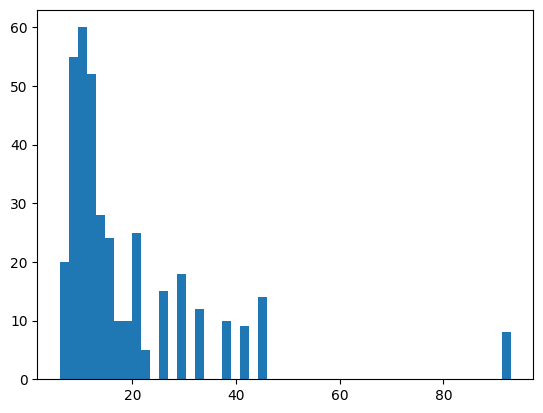

In [23]:
plt.hist([len(fs) for fs in  train['feature_nums']], bins=50)
plt.plot()

## Saving test narrations

In [24]:
with open('../jb_data/narrations_only_test.txt', 'w') as f:
    for item in test['narration']:
        f.writelines(item + '\n')
                


## Dataset information

Statistics for the train set (length 375)

The first question is either:
* Summarise the prediction (336 times)
* Summarise the ranking of the features (39 times)

The second question is either:
* Give an overview of the top features (250 times)
* Give direction of influence of the following features (86 times)
* Summarise the ranking of the features (39 times) ACCOUNTED FOR

The third question is either:
* Compare and contrast the following features (355 times)
* 'For these top features, what are the respective directions of influence on the prediction?'(20 times)

198 have 4 or more questions
* Describe the direction of the following features (121 times)
* Summarise the unimportant features (73 times)
* 'Describe the degree of impact of the following features: [blank]?' (4 times)

39 have 5 or more questions
* 'Provide a statement on the features with the least impact on the prediction made for this test case.' (39 times) ACCOUNTED FOR



```python
reg = re.compile(r'F\d+')
Counter([l['narrative_questions'][1] for l in train if l['narrative_questions'][0] == 'Provide a statement summarizing the prediction made for the test case.']).most_common()
[[' '.join(reg.findall(n)) for n in l['narrative_questions']] for l in train if l['narrative_questions'][0] == 'Provide a statement summarizing the prediction made for the test case.']
[' '.join(l['feature_nums']) for l in train if l['narrative_questions'][0] == 'Provide a statement summarizing the prediction made for the test case.']
```
A. For 99 cases the format is:
* 'In a single sentence, state the prediction output of the model for the selected test case along with the confidence level of the prediction (if applicable).'
* "In no less three sentences, provide a brief overview of the features with a higher impact on the model's output prediction."
* 'Describe the degree of impact of the following features: [0-4 fts (after first 7-9)]?' (3 times there are 0)

B. For 78 cases the format is:
* "For this test instance, provide information on the predicted label along with the confidence level of the model's decision." -->
* "Summarize the top features influencing the model's decision along with the respective directions of influence on the prediction?"
* 'Summarize the direction of influence of the features [the next 3-4 features (after first 2-4)] with moderate impact on the prediction made for this test case.'

C. For 53 cases the format is:
* 'Summarize the prediction for the given test example?'
* "In two sentences, provide a brief overview of the features with a higher impact on the model's output prediction."
* 'Compare and contrast the impact of the following attributes  [3-4 seemingly random features] on the model’s prediction of [C1/C2].'
* 'Summarize the set of features has little to no impact on the prediction?'

D. For 20 cases the format is:
* 'Summarize the prediction for the given test example?'
* 'For this test case, summarize the top features influencing the model's decision.'
* 'For these top features, what are the respective directions of influence on the prediction?'
* 'Provide a statement on the set of features has limited impact on the prediction of [C1/C2] by the model for the given test example?'

E. For 39 cases the format is:
* 'Summarize the prediction made for the test under consideration along with the likelihood of the different possible class labels.'
* 'Provide a statement summarizing the ranking of the features as shown in the feature impact plot.'
* 'Compare the direction of impact of the features: [2-5 top features].'
* 'Summarize the direction of influence of the features [the next 3-4 features] with moderate impact on the prediction made for this test case.'
* 'Provide a statement on the features with the least impact on the prediction made for this test case.'

F. For 44 cases the format is:
* 'Provide a statement summarizing the prediction made for the test case.'
* 'For the current test instance, describe the direction of influence of the following features: [2-5 top features]'
* 'Compare and contrast the impact of the following features [the next 3-4 features] on the model’s prediction of [C1/C2].'
* 'Describe the degree of impact of the following features: [the next 0-4 features]?' (usually 4 unless there are not enough features)

G. For 39 cases the format is:
* 'Provide a statement summarizing the ranking of the features as shown in the feature impact plot.'
* 'Summarize the direction of influence of the features [2-5 top features] on the prediction made for this test case.'
* 'Compare the direction of impact of the features: [the next 3-4 features].'
* 'Describe the degree of impact of the following features:[the next 0-4 features]'

H. For 3 cases the format is:
* 'Summarize the prediction made for the test under consideration along with the likelihood of the different possible class labels.'
* 'Summarize the direction of influence of the variables [2-3 top features] on the prediction made for this test case.' -->
* 'Compare the direction of impact of the variables: [the next 3-4 features].'
* 'Describe the degree of impact of the following variables: [the next 3-4 features]?'

| Q | A | New Q |
| ---- | ---- | ---- |
| Summarise the prediction | Note: In E (39) this question is asked across 2 sentences | Summarise the prediction |
| Summarise the top features | A-D (250): Top features aren't named, just says 'top features' | a) Summarise the top features |
|   | E-H  (125) specifies 2-5 top features | b) Summarise these top features ([fts]) |
|   | Note: In D (20) this question is asked across 2 sentences |   |
| Summarise moderate fts | A (99): 3-4 named fts (after first 7-9) | Summarise these moderate features ([fts]) |
|   | B, C (131): 3-4 named fts (after first 2-4) |   |
|   | E-H (125) named fts (the next 3-4) |   |
|   | Note: D (20) does not have this Q
| Summarise more/lower fts | C-E (112) describe fts with little to no impact (fts not named) | a) Summarise the negligible features |
|   | F-H (86) 0-4 named fts | b) Summarise these negligible features ([fts]) |
|   | Note: A,B (177) do not have a 4th Q |   |


In [25]:
train = load_dataset("james-burton/textual-explanations", split='train')

Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [26]:
Counter([l['narrative_questions'][0] for l in train ]).most_common()

[('In a single sentence, state the prediction output of the model for the selected test case along with the confidence level of the prediction (if applicable).',
  99),
 ("For this test instance, provide information on the predicted label along with the confidence level of the model's decision.",
  78),
 ('Summarize the prediction for the given test example?', 73),
 ('Provide a statement summarizing the prediction made for the test case.',
  44),
 ('Summarize the prediction made for the test under consideration along with the likelihood of the different possible class labels.',
  42),
 ('Provide a statement summarizing the ranking of the features as shown in the feature impact plot.',
  39)]

In [27]:
reg = re.compile(r'F\d+')
[[' '.join(reg.findall(n)) for n in l['narrative_questions']] for l in train if all((l['narrative_questions'][1] == "In two sentences, provide a brief overview of the features with a higher impact on the model's output prediction.", 1==1))]


[['', '', 'F5 F18 F1', ''],
 ['', '', 'F10 F12 F2 F21', ''],
 ['', '', 'F3 F10 F2 F6', ''],
 ['', '', 'F11 F2 F10 F15', ''],
 ['', '', 'F31 F15 F7', ''],
 ['', '', 'F4 F13 F16 F14', ''],
 ['', '', 'F3 F14 F11 F8', ''],
 ['', '', 'F2 F4 F5', ''],
 ['', '', 'F3 F13 F15', ''],
 ['', '', 'F12 F11 F19', ''],
 ['', '', 'F9 F59 F63', ''],
 ['', '', 'F13 F7 F18 F21', ''],
 ['', '', 'F24 F14 F30 F18', ''],
 ['', '', 'F4 F7 F5 F2', ''],
 ['', '', 'F4 F1 F14', ''],
 ['', '', 'F17 F26 F15', ''],
 ['', '', 'F8 F7 F1 F4', ''],
 ['', '', 'F11 F9 F4', ''],
 ['', '', 'F7 F2 F8', ''],
 ['', '', 'F15 F5 F4', ''],
 ['', '', 'F2 F10 F1 F4', ''],
 ['', '', 'F18 F12 F30 F10', ''],
 ['', '', 'F8 F7 F9 F1', ''],
 ['', '', 'F4 F10 F5 F9', ''],
 ['', '', 'F7 F6 F8', ''],
 ['', '', 'F4 F9 F7', ''],
 ['', '', 'F19 F22 F4', ''],
 ['', '', 'F8 F6 F4 F3', ''],
 ['', '', 'F9 F3 F2 F10', ''],
 ['', '', 'F2 F4 F6', ''],
 ['', '', 'F5 F6 F7', ''],
 ['', '', 'F8 F5 F7 F1', ''],
 ['', '', 'F9 F8 F16 F15', ''],
 ['', '', 'F

In [28]:
Counter([l['narrative_questions'][4] for l in train if all((l['narrative_questions'][0] == 'Summarize the prediction made for the test under consideration along with the likelihood of the different possible class labels.', l['narrative_questions'][1]=='Provide a statement summarizing the ranking of the features as shown in the feature impact plot.'))]).most_common()
# Counter([len(l['narrative_questions']) for l in train if l['narrative_questions'][0] == 'In a single sentence, state the prediction output of the model for the selected test case along with the confidence level of the prediction (if applicable).']).most_common()

[('Provide a statement on the features with the least impact on the prediction made for this test case.',
  39)]

## Investigating answers to the questions

### Q1: Summarise the ranking of the features
What does this mean?


In [29]:
[l['narration'].split(". ")[0] for l in train if l['narrative_questions'][0] == 'Provide a statement summarizing the ranking of the features as shown in the feature impact plot.']

['The classifier is 69.02% certain that the given case is under the class label C1, implying that the likelihood of C2 is only 30.98%',
 "According to the machine learning model, it is more likely that the case's label is C2, with a certainty of 100.0%, and this prediction decision is mainly based on the effects of the following features: F8, F10, F6, F9, and F1 on the model",
 'The given case is likely C2 with a confidence level of 87.50% judged based on the values of the input features supplied to the classifier and according to the attributions analysis, F9 and F2 have a high degree of impact',
 'The model has classified the instance as C2 due to the effects of the following features: F5, F8, F6, and F2',
 'The likelihood of C2 being the correct label for the selected case or instance is 67.54% according to the classifier',
 'The confidence level score with respect to each class label suggests that this case should be labelled as C2',
 'The prediction probability of C1 is 17.93% and


Answers to this question are almost always still the same as what we would have got for the other question: A statement on the prediction of the model.

### Q2: Summarise the ranking of the features

Is this the same as when asked in Q1?

In [30]:
[l['narration'].split(". ")[1] for l in train if l['narrative_questions'][1] == 'Provide a statement summarizing the ranking of the features as shown in the feature impact plot.']

[" Regarding the classifier's decision, there is close to an even split on the probability of either of the possible labels is the correct label but the classifier chooses the label as C2",
 'F6 and F10 are deemed the most important features whereas on the other hand all the other features have moderate to minimal amounts of influence',
 'The most relevant features that led to the C1 classification verdict are F5, F30, F26, F17, and F15',
 "According to the attribution analysis conducted, the different input variables have varying degrees of influence on the model's decision here",
 'F12 and F1 are the most important variables with respect to this classification verdict while all other variables are shown to have a medium or low impact',
 'F24 had the largest impact, followed by F23, F9, F18, F14, F10, F11, F2, F8, F21, F20, F27, F4, F12, F15, F19, F13, F16, F30, and finally, F29, which had the smallest non-zero impact',
 'F11 is by far the most influential feature whereas F4, F6, and 

Seems to just be a 2 sentence question asking the same thing as the single sentence

### Q3: 'For these top features, what are the respective directions of influence on the prediction?' Are these top features named?

For these 20 instances,
* 'Summarize the prediction for the given test example?'
* 'For this test case, summarize the top features influencing the model's decision.'
* 'For these top features, what are the respective directions of influence on the prediction?'
* 'Provide a statement on the set of features has limited impact on the prediction of [C1/C2] by the model for the given test example?'


In [31]:
reg = re.compile(r'F\d+')
[[reg.findall(n) for n in l['narrative_questions']] for l in train if l['narrative_questions'][2] == 'For these top features, what are the respective directions of influence on the prediction?']
Counter([len(l['narrative_questions']) for l in train if l['narrative_questions'][2] == 'For these top features, what are the respective directions of influence on the prediction?']).most_common()

[(4, 20)]

## Analysis on simplified questions

### Top features

In [32]:
reg = re.compile(r'F\d+')
mentions = [[reg.findall(n)for n in l['narrative_questions']][1] for l in simple_train if l['narrative_questions'][1][:28] == "Summarise these top features"]
all_fts = [l['feature_nums'] for l in simple_train if l['narrative_questions'][1][:28] == "Summarise these top features"]
indexes = [[narr.index(val) for val in mention] for narr, mention in zip(all_fts, mentions)]

rev_indexes = [[narr[::-1].index(val) for val in mention] for narr, mention in zip(all_fts, mentions)]

for i, r_i in zip(indexes, rev_indexes):
    print(i, r_i)

[0, 1] [19, 18]
[0, 1] [11, 10]
[0, 1] [9, 8]
[0, 1] [6, 5]
[0, 1, 2] [19, 18, 17]
[0, 1] [29, 28]
[0, 1, 2, 3, 4] [37, 36, 35, 34, 33]
[0, 1, 2, 3] [10, 9, 8, 7]
[0, 1] [11, 10]
[0, 1, 2, 3, 4] [29, 28, 27, 26, 25]
[0, 1, 2, 3, 4] [8, 7, 6, 5, 4]
[0, 1, 2, 3] [8, 7, 6, 5]
[0, 1, 2] [8, 7, 6]
[0, 1, 2, 3, 4] [18, 17, 16, 15, 14]
[0, 1, 2, 3, 4] [13, 12, 11, 10, 9]
[0, 1, 2] [19, 18, 17]
[0, 1, 2, 3, 4] [32, 31, 30, 29, 28]
[0, 1, 2, 3, 4] [37, 36, 35, 34, 33]
[0, 1] [45, 44]
[0, 1] [13, 12]
[0, 1, 2, 3] [10, 9, 8, 7]
[0, 1, 2, 3] [10, 9, 8, 7]
[0, 1] [41, 40]
[0, 1, 2] [18, 17, 16]
[0, 1, 2, 3, 4] [9, 8, 7, 6, 5]
[0, 1] [41, 40]
[0, 1] [14, 13]
[0, 1, 2, 3, 4] [37, 36, 35, 34, 33]
[0, 1, 2, 3, 4] [37, 36, 35, 34, 33]
[0, 1, 2] [7, 6, 5]
[0, 1] [92, 91]
[0, 1, 2, 3, 4] [45, 44, 43, 42, 41]
[0, 1] [29, 28]
[0, 1] [29, 28]
[0, 1, 2, 3, 4] [13, 12, 11, 10, 9]
[0, 1, 2, 3, 4] [6, 5, 4, 3, 2]
[0, 1, 2, 3] [11, 10, 9, 8]
[0, 1, 2, 3] [10, 9, 8, 7]
[0, 1] [6, 5]
[0, 1] [41, 40]
[0, 1] [8, 7]
[

In [33]:
Counter([item for sublist in indexes for item in sublist]).most_common()

[(0, 125), (1, 125), (2, 71), (3, 47), (4, 24)]

### Moderate features

In [34]:
reg = re.compile(r'F\d+')
mentions = [[reg.findall(n)for n in l['narrative_questions']][2] for l in simple_train if l['narrative_questions'][2][:33] == "Summarise these moderate features"]
all_fts = [l['feature_nums'] for l in simple_train if l['narrative_questions'][2][:33] == "Summarise these moderate features"]
indexes = [[narr.index(val) for val in mention] for narr, mention in zip(all_fts, mentions)]

rev_indexes = [[narr[::-1].index(val) for val in mention] for narr, mention in zip(all_fts, mentions)]

for i, r_i in zip(indexes, rev_indexes):
    print(i, r_i)

[5, 6, 7] [10, 9, 8]
[2, 3, 4, 5] [17, 16, 15, 14]
[] []
[2, 3, 4, 5] [9, 8, 7, 6]
[5, 6, 7] [4, 3, 2]
[6, 7, 8] [12, 11, 10]
[6, 7, 8] [19, 18, 17]
[3, 4, 5] [16, 15, 14]
[2, 3, 4, 5] [9, 8, 7, 6]
[13, 1, 24, 6] [12, 24, 1, 19]
[4, 5, 6] [88, 87, 86]
[2, 3, 4, 5] [9, 8, 7, 6]
[3, 4, 5] [8, 7, 6]
[2, 3, 4, 5] [8, 7, 6, 5]
[2, 3, 4, 5] [7, 6, 5, 4]
[2, 3, 4, 5] [4, 3, 2, 1]
[2, 3, 4, 5] [43, 42, 41, 40]
[7, 8, 9] [12, 11, 10]
[2, 3, 4, 5] [14, 13, 12, 11]
[8, 9] [1, 0]
[6, 7, 8] [2, 1, 0]
[6] [0]
[3, 4, 5] [16, 15, 14]
[4, 5, 6] [41, 40, 39]
[6, 7, 8] [2, 1, 0]
[2, 3, 4, 5] [6, 5, 4, 3]
[8, 9, 10] [3, 2, 1]
[2, 3, 4, 5] [27, 26, 25, 24]
[2, 3, 4, 5] [23, 22, 21, 20]
[7, 8, 9] [4, 3, 2]
[3, 4, 5] [16, 15, 14]
[5, 6, 7] [32, 31, 30]
[4, 5, 6] [6, 5, 4]
[6, 7, 8, 9] [23, 22, 21, 20]
[2, 3, 4, 5] [9, 8, 7, 6]
[6, 7, 8] [2, 1, 0]
[6, 7, 8, 9] [31, 30, 29, 28]
[5, 6, 7] [3, 2, 1]
[5, 6, 7] [24, 23, 22]
[5, 6, 7] [3, 2, 1]
[8, 9, 10] [24, 23, 22]
[2, 3, 4, 5] [14, 13, 12, 11]
[6, 7, 8, 9] [5, 

In [35]:
Counter([item for sublist in indexes for item in sublist]).most_common()

[(5, 255),
 (4, 200),
 (3, 163),
 (6, 153),
 (7, 129),
 (2, 109),
 (8, 89),
 (9, 57),
 (10, 11),
 (13, 1),
 (1, 1),
 (24, 1)]

### Negligible features

In [36]:
reg = re.compile(r'F\d+')
mentions = [[reg.findall(n)for n in l['narrative_questions']][-1] for l in simple_train if l['narrative_questions'][3][:35] == "Summarise these negligible features"]
all_fts = [l['feature_nums'] for l in simple_train if l['narrative_questions'][3][:35] == "Summarise these negligible features"]
indexes = [[narr.index(val) for val in mention] for narr, mention in zip(all_fts, mentions)]

rev_indexes = [[narr[::-1].index(val) for val in mention] for narr, mention in zip(all_fts, mentions)]

for i, r_i in zip(indexes, rev_indexes):
    print(i, r_i)

[6, 7, 8, 9] [3, 2, 1, 0]
[6] [0]
[6, 7, 8, 9] [13, 12, 11, 10]
[7, 8, 9] [3, 2, 1]
[8] [0]
[7, 8] [1, 0]
[6, 7, 8] [2, 1, 0]
[8, 9, 10] [5, 4, 3]
[8, 9, 10] [24, 23, 22]
[7, 8, 9] [3, 2, 1]
[7, 8, 9] [3, 2, 1]
[6, 7, 8, 9] [35, 34, 33, 32]
[6, 7, 8, 9] [35, 34, 33, 32]
[6, 7, 8, 9] [8, 7, 6, 5]
[8, 9, 10] [37, 36, 35]
[6, 7, 8] [23, 22, 21]
[6, 7, 8, 9] [23, 22, 21, 20]
[8, 9, 10] [5, 4, 3]
[7, 8, 9] [3, 2, 1]
[6] [0]
[6, 7, 8] [35, 34, 33]
[6, 7, 8] [2, 1, 0]
[6, 7, 8, 9] [5, 4, 3, 2]
[8, 9, 10] [3, 2, 1]
[6, 7, 8, 9] [8, 7, 6, 5]
[6, 7, 8, 9] [35, 34, 33, 32]
[6, 7, 8, 9] [13, 12, 11, 10]
[6, 7, 8, 9] [3, 2, 1, 0]
[6, 7] [1, 0]
[7, 8] [1, 0]
[6, 7] [1, 0]
[6, 7, 8, 9] [35, 34, 33, 32]
[6, 7, 8, 9] [8, 7, 6, 5]
[7, 8, 9] [85, 84, 83]
[6] [0]
[] []
[6] [0]
[6, 7, 8, 9] [10, 9, 8, 7]
[8, 9, 10] [5, 4, 3]
[7, 8, 9] [3, 2, 1]
[7, 8, 9] [3, 2, 1]
[6, 7, 8, 9] [12, 11, 10, 9]
[6, 7, 8, 9] [13, 12, 11, 10]
[7, 8, 9] [7, 6, 5]
[7, 8, 9] [8, 7, 6]
[6, 7, 8] [35, 34, 33]
[7, 8, 9] [4, 3, 2]
[8

In [37]:
Counter([item for sublist in indexes for item in sublist]).most_common()

[(8, 73), (7, 62), (9, 50), (6, 49), (10, 11)]

### For when features weren't included in the question, which features were mentioned in the narration?

### Top features

In [38]:
reg = re.compile(r'F\d+')
mentions = [[reg.findall(n)for n in sent_tokenize(l['narration'])] for l in simple_train if l['narrative_questions'][1][:26] == "Summarise the top features"]
all_fts = [l['feature_nums'] for l in simple_train if l['narrative_questions'][1][:26] == "Summarise the top features"]
indexes = [[[narr.index(val) if len(sent)>0 else None for val in sent ] for sent in mention] for narr, mention in zip(all_fts, mentions)]
rev_indexes = [[[narr[::-1].index(val) if len(sent)>0 else None for val in sent ] for sent in mention] for narr, mention in zip(all_fts, mentions)]

mentions2 = [[reg.findall(n)for n in sent_tokenize(l['narration'])] for l in simple_train if l['narrative_questions'][1][:26] != "Summarise the top features"]
all_fts2 = [l['feature_nums'] for l in simple_train if l['narrative_questions'][1][:26] != "Summarise the top features"]
indexes2 = [[[narr.index(val) if len(sent)>0 else None for val in sent ] for sent in mention] for narr, mention in zip(all_fts2, mentions2)]

for i, r_i in zip(indexes, rev_indexes):
    print(i)#, r_i)
    # print(r_i)

[[], [], [0, 2, 1, 14, 13, 15], [0, 2, 1, 4], [6, 9, 7, 10], [3, 5, 8, 13, 14, 15], []]
[[], [0, 1, 2, 3, 4, 5], [0], [1, 2, 3], [0]]
[[], [1, 2, 0], [5, 3, 8, 7, 6], [4, 9, 10], [0, 2, 1], [11]]
[[], [], [1, 0, 2], [6, 8, 7, 9, 3, 4, 5], [0, 1, 3, 6, 8], [2, 4, 7, 5, 9]]
[[], [], [0, 1], [2, 3, 4, 5], [2, 5, 8, 10, 17], [0, 1, 3, 4, 6, 7]]
[[], [0, 1, 2], [20, 21, 22, 23, 24, 25], [6, 9, 10, 14, 15, 16], [0, 1, 2, 4, 3, 5]]
[[], [1, 3, 2, 0, 0, 1, 3, 2], [5, 4, 2], [17, 19, 16, 18]]
[[], [0, 1, 2, 3], [20, 21, 22, 23, 24, 25], [0, 1, 2], [3, 5, 6, 7], [4, 8, 12, 13, 14, 15, 17, 18, 19]]
[[], [0, 1, 2, 3, 4, 6, 5], [7, 8, 9, 11, 10, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23], [], [5, 8, 17, 18, 19], [0, 1, 2, 3]]
[[], [0, 1, 2, 3], [2, 3, 4], [11, 9, 10], [5, 8, 7, 6], [4, 9, 1, 2, 0]]
[[], [0, 1, 3, 2, 9, 10, 11], [0, 1, 2, 3, 6, 8, 10], [4, 5, 11, 9, 7], []]
[[], [], [0, 1, 2, 3], [4, 5, 6], [9, 10, 11], [7, 8], [1, 0, 3, 2]]
[[], [], [0, 1, 2, 3, 8, 9, 10], [4, 5, 6, 7], [0, 

In [46]:
len(mentions[0])

7

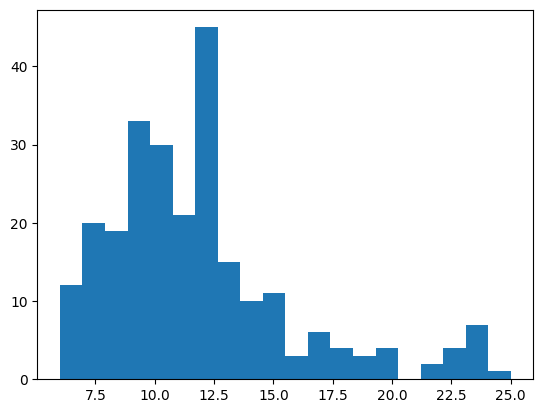

In [54]:
# join mentions[0] into 1 list
num_fts = [len(set([item for sublist in mention for item in sublist])) for mention in mentions]

# Plot num_fts
plt.hist(num_fts, bins=20)
plt.show()

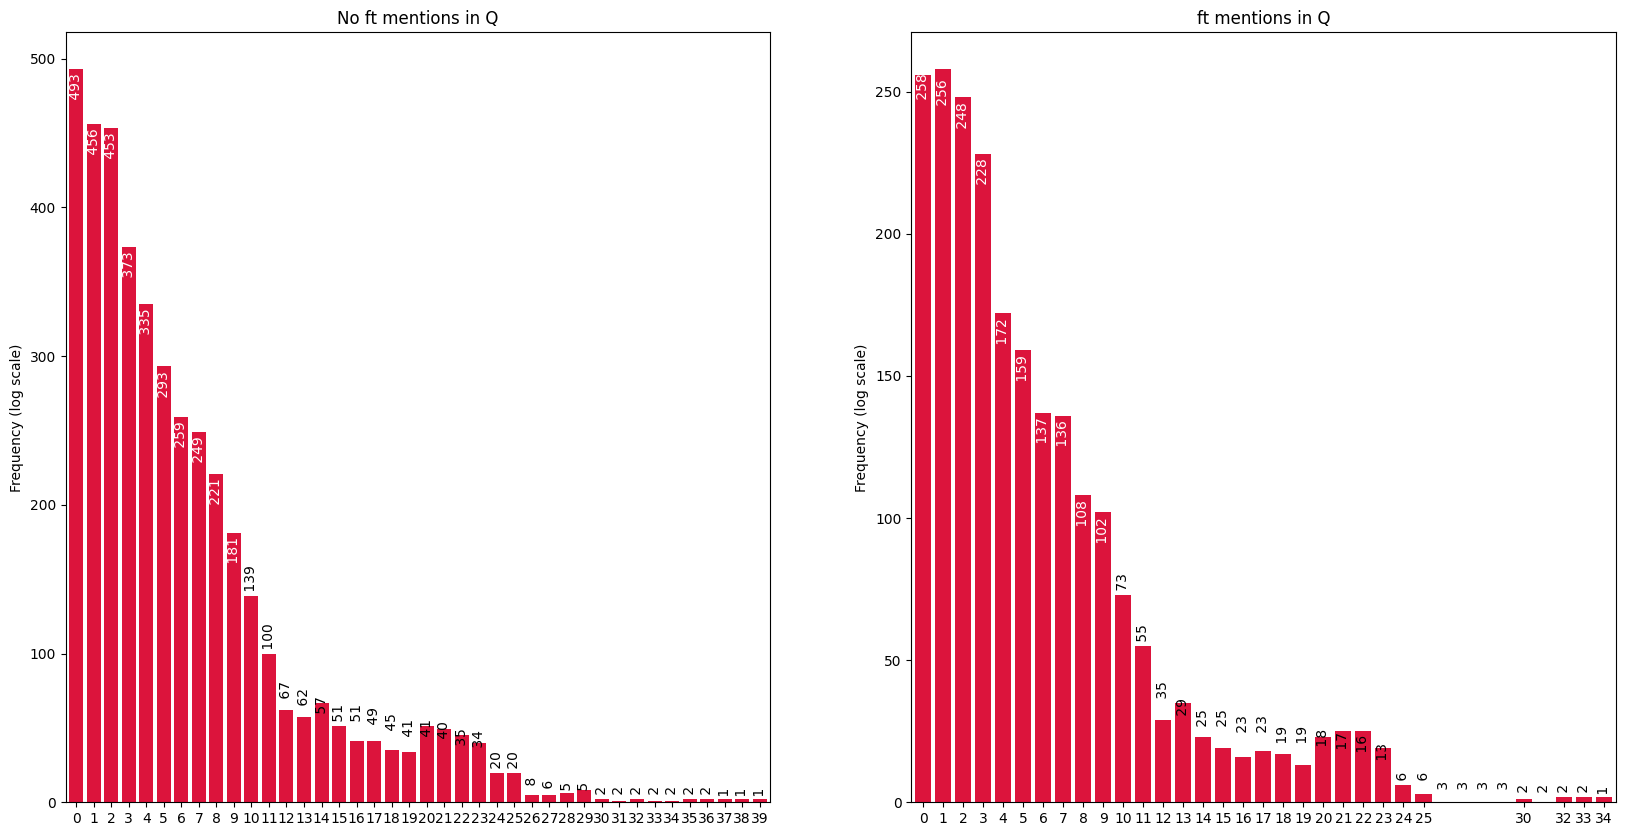

In [79]:
tf = Counter([item for group in indexes for sublist in group for item in sublist]).most_common()

y = [count for tag, count in tf]
x = [tag for tag, count in tf]

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].bar(x, y, color='crimson')
axs[0].set_title("No ft mentions in Q")
axs[0].set_ylabel("Frequency number appears in answer")
# axs[0].yscale('log') # optionally set a log scale for the y-axis

axs[0].set_xticks(x, rotation=90)
for i, (tag, count) in enumerate(tf):
    axs[0].text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
axs[0].set_xlim(-0.6, len(x)-0.4) # optionally set tighter x lims

tf2 = Counter([item for group in indexes2 for sublist in group for item in sublist]).most_common()
y2 = [count for tag, count in tf2]
x2 = [tag for tag, count in tf2]

axs[1].bar(x2, y2, color='crimson')

axs[1].set_title("ft mentions in Q")
axs[1].set_ylabel("Frequency number appears in answer")
# axs[1].yscale('log') # optionally set a log scale for the y-axis

axs[1].set_xticks(x2, rotation=90)
for i, (tag, count) in enumerate(tf2):
    axs[1].text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
axs[1].set_xlim(-0.6, len(x2)-0.4) # optionally set tighter x lims

plt.show()


### Moderate features

In [49]:
reg = re.compile(r'F\d+')
mentions = [[reg.findall(n)for n in l['narrative_questions']][2] for l in simple_train if l['narrative_questions'][2][:33] == "Summarise these moderate features"]
all_fts = [l['feature_nums'] for l in simple_train if l['narrative_questions'][2][:33] == "Summarise these moderate features"]
indexes = [[narr.index(val) for val in mention] for narr, mention in zip(all_fts, mentions)]

rev_indexes = [[narr[::-1].index(val) for val in mention] for narr, mention in zip(all_fts, mentions)]

for i, r_i in zip(indexes, rev_indexes):
    print(i, r_i)

[5, 6, 7] [10, 9, 8]
[2, 3, 4, 5] [17, 16, 15, 14]
[] []
[2, 3, 4, 5] [9, 8, 7, 6]
[5, 6, 7] [4, 3, 2]
[6, 7, 8] [12, 11, 10]
[6, 7, 8] [19, 18, 17]
[3, 4, 5] [16, 15, 14]
[2, 3, 4, 5] [9, 8, 7, 6]
[13, 1, 24, 6] [12, 24, 1, 19]
[4, 5, 6] [88, 87, 86]
[2, 3, 4, 5] [9, 8, 7, 6]
[3, 4, 5] [8, 7, 6]
[2, 3, 4, 5] [8, 7, 6, 5]
[2, 3, 4, 5] [7, 6, 5, 4]
[2, 3, 4, 5] [4, 3, 2, 1]
[2, 3, 4, 5] [43, 42, 41, 40]
[7, 8, 9] [12, 11, 10]
[2, 3, 4, 5] [14, 13, 12, 11]
[8, 9] [1, 0]
[6, 7, 8] [2, 1, 0]
[6] [0]
[3, 4, 5] [16, 15, 14]
[4, 5, 6] [41, 40, 39]
[6, 7, 8] [2, 1, 0]
[2, 3, 4, 5] [6, 5, 4, 3]
[8, 9, 10] [3, 2, 1]
[2, 3, 4, 5] [27, 26, 25, 24]
[2, 3, 4, 5] [23, 22, 21, 20]
[7, 8, 9] [4, 3, 2]
[3, 4, 5] [16, 15, 14]
[5, 6, 7] [32, 31, 30]
[4, 5, 6] [6, 5, 4]
[6, 7, 8, 9] [23, 22, 21, 20]
[2, 3, 4, 5] [9, 8, 7, 6]
[6, 7, 8] [2, 1, 0]
[6, 7, 8, 9] [31, 30, 29, 28]
[5, 6, 7] [3, 2, 1]
[5, 6, 7] [24, 23, 22]
[5, 6, 7] [3, 2, 1]
[8, 9, 10] [24, 23, 22]
[2, 3, 4, 5] [14, 13, 12, 11]
[6, 7, 8, 9] [5, 

In [50]:
Counter([item for sublist in indexes for item in sublist]).most_common()

[(5, 255),
 (4, 200),
 (3, 163),
 (6, 153),
 (7, 129),
 (2, 109),
 (8, 89),
 (9, 57),
 (10, 11),
 (13, 1),
 (1, 1),
 (24, 1)]

### Negligible features

In [51]:
reg = re.compile(r'F\d+')
mentions = [[reg.findall(n)for n in l['narrative_questions']][-1] for l in simple_train if l['narrative_questions'][3][:35] == "Summarise these negligible features"]
all_fts = [l['feature_nums'] for l in simple_train if l['narrative_questions'][3][:35] == "Summarise these negligible features"]
indexes = [[narr.index(val) for val in mention] for narr, mention in zip(all_fts, mentions)]

rev_indexes = [[narr[::-1].index(val) for val in mention] for narr, mention in zip(all_fts, mentions)]

for i, r_i in zip(indexes, rev_indexes):
    print(i, r_i)

[6, 7, 8, 9] [3, 2, 1, 0]
[6] [0]
[6, 7, 8, 9] [13, 12, 11, 10]
[7, 8, 9] [3, 2, 1]
[8] [0]
[7, 8] [1, 0]
[6, 7, 8] [2, 1, 0]
[8, 9, 10] [5, 4, 3]
[8, 9, 10] [24, 23, 22]
[7, 8, 9] [3, 2, 1]
[7, 8, 9] [3, 2, 1]
[6, 7, 8, 9] [35, 34, 33, 32]
[6, 7, 8, 9] [35, 34, 33, 32]
[6, 7, 8, 9] [8, 7, 6, 5]
[8, 9, 10] [37, 36, 35]
[6, 7, 8] [23, 22, 21]
[6, 7, 8, 9] [23, 22, 21, 20]
[8, 9, 10] [5, 4, 3]
[7, 8, 9] [3, 2, 1]
[6] [0]
[6, 7, 8] [35, 34, 33]
[6, 7, 8] [2, 1, 0]
[6, 7, 8, 9] [5, 4, 3, 2]
[8, 9, 10] [3, 2, 1]
[6, 7, 8, 9] [8, 7, 6, 5]
[6, 7, 8, 9] [35, 34, 33, 32]
[6, 7, 8, 9] [13, 12, 11, 10]
[6, 7, 8, 9] [3, 2, 1, 0]
[6, 7] [1, 0]
[7, 8] [1, 0]
[6, 7] [1, 0]
[6, 7, 8, 9] [35, 34, 33, 32]
[6, 7, 8, 9] [8, 7, 6, 5]
[7, 8, 9] [85, 84, 83]
[6] [0]
[] []
[6] [0]
[6, 7, 8, 9] [10, 9, 8, 7]
[8, 9, 10] [5, 4, 3]
[7, 8, 9] [3, 2, 1]
[7, 8, 9] [3, 2, 1]
[6, 7, 8, 9] [12, 11, 10, 9]
[6, 7, 8, 9] [13, 12, 11, 10]
[7, 8, 9] [7, 6, 5]
[7, 8, 9] [8, 7, 6]
[6, 7, 8] [35, 34, 33]
[7, 8, 9] [4, 3, 2]
[8

In [52]:
Counter([item for sublist in indexes for item in sublist]).most_common()

[(8, 73), (7, 62), (9, 50), (6, 49), (10, 11)]

In [84]:
[i for i, fts in enumerate(train['feature_nums']) if len(fts) >45 ]

[10,
 17,
 25,
 66,
 73,
 95,
 99,
 100,
 145,
 174,
 180,
 226,
 244,
 245,
 254,
 299,
 309,
 328,
 336,
 342,
 354,
 365]

## Inputs getting cut off

In [122]:
lin = 'essel'
max_fts = 30
model = 't5-base'
max_input_len = 500

output_dict = {}

for lin in ['essel', 'ord_first', 'ft_first']:
    for max_fts in [30, 40, 50]:
        for max_input_len in [400, 500]:
            for model in ['t5-base', 'facebook/bart-base']:
                print(lin, max_fts, model, max_input_len)

                tokenizer = AutoTokenizer.from_pretrained(model)

                dataset = load_dataset("james-burton/textual-explanations")

                dataset = dataset.map(lambda x: simplify_narr_question(label_qs(x)),
                                        load_from_cache_file=False)

                # Form the linearised or stepwise (and linearised) input
                dataset = dataset.map(
                    lambda x: linearise_input(x, lin, max_fts),
                    load_from_cache_file=False
                    ) 

                # Convert to tokens
                dataset = dataset.map(
                    lambda x: convert_to_features(x, tokenizer, max_input_len), 
                    batched=True, load_from_cache_file=False
                    )
                decoded_train = tokenizer.batch_decode(dataset['train']['input_ids'], skip_special_tokens=False)

                [len(d) for d in decoded_train]
                # Count number of times the string '<pad>' appears in the string 
                # (i.e. the number of padding tokens)
                max_outs = sum([len(re.findall('<pad>', d))==0 for d in decoded_train])
                output_dict[(lin, max_fts, model, max_input_len)] = max_outs
                print(max_outs)

essel 30 t5-base 400


/home/james/CodingProjects/Local_level_model_explanations/env/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--t

43
essel 30 facebook/bart-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 54.75ba/s]


0
essel 30 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 48.24ba/s]


0
essel 30 facebook/bart-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 44.33ba/s]


0
essel 40 t5-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 48.38ba/s]


65
essel 40 facebook/bart-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 54.93ba/s]


0
essel 40 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 59.48ba/s]


26
essel 40 facebook/bart-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 55.98ba/s]


0
essel 50 t5-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 51.39ba/s]


65
essel 50 facebook/bart-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 43.51ba/s]


30
essel 50 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 59.48ba/s]


35
essel 50 facebook/bart-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 51.60ba/s]


0
ord_first 30 t5-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 57.05ba/s]


52
ord_first 30 facebook/bart-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 46.48ba/s]


70
ord_first 30 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 58.24ba/s]


0
ord_first 30 facebook/bart-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 46.41ba/s]


0
ord_first 40 t5-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 59.08ba/s]


63
ord_first 40 facebook/bart-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 58.61ba/s]


70
ord_first 40 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 55.75ba/s]


33
ord_first 40 facebook/bart-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 53.13ba/s]


36
ord_first 50 t5-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 58.09ba/s]


63
ord_first 50 facebook/bart-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 56.07ba/s]


70
ord_first 50 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 55.08ba/s]


34
ord_first 50 facebook/bart-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 52.97ba/s]


36
ft_first 30 t5-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 59.69ba/s]


21
ft_first 30 facebook/bart-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 57.94ba/s]


33
ft_first 30 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 45.06ba/s]


0
ft_first 30 facebook/bart-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 36.38ba/s]


0
ft_first 40 t5-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 57.44ba/s]


55
ft_first 40 facebook/bart-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 43.45ba/s]


60
ft_first 40 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 55.59ba/s]


21
ft_first 40 facebook/bart-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 55.71ba/s]


18
ft_first 50 t5-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 59.21ba/s]


55
ft_first 50 facebook/bart-base 400


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 53.83ba/s]


60
ft_first 50 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 57.81ba/s]


30
ft_first 50 facebook/bart-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 54.43ba/s]


31


In [123]:
output_dict

{('essel', 30, 't5-base', 400): 43,
 ('essel', 30, 'facebook/bart-base', 400): 0,
 ('essel', 30, 't5-base', 500): 0,
 ('essel', 30, 'facebook/bart-base', 500): 0,
 ('essel', 40, 't5-base', 400): 65,
 ('essel', 40, 'facebook/bart-base', 400): 0,
 ('essel', 40, 't5-base', 500): 26,
 ('essel', 40, 'facebook/bart-base', 500): 0,
 ('essel', 50, 't5-base', 400): 65,
 ('essel', 50, 'facebook/bart-base', 400): 30,
 ('essel', 50, 't5-base', 500): 35,
 ('essel', 50, 'facebook/bart-base', 500): 0,
 ('ord_first', 30, 't5-base', 400): 52,
 ('ord_first', 30, 'facebook/bart-base', 400): 70,
 ('ord_first', 30, 't5-base', 500): 0,
 ('ord_first', 30, 'facebook/bart-base', 500): 0,
 ('ord_first', 40, 't5-base', 400): 63,
 ('ord_first', 40, 'facebook/bart-base', 400): 70,
 ('ord_first', 40, 't5-base', 500): 33,
 ('ord_first', 40, 'facebook/bart-base', 500): 36,
 ('ord_first', 50, 't5-base', 400): 63,
 ('ord_first', 50, 'facebook/bart-base', 400): 70,
 ('ord_first', 50, 't5-base', 500): 34,
 ('ord_first', 

In [99]:
decoded_train[0]

'| predicted class | C1 64.66% | other classes | C2 35.34% | features | F5 && F8 && F1 && F11 && F7 && F6 && F16 && F15 && F13 && F3 && F14 && F9 && F10 && F2 && F12 && F4 | postive features | F5 && F8 && F1 && F7 && F16 && F15 && F3 && F14 && F9 && F10 | negative features | F11 && F6 && F13 && F2 && F12 && F4 | negligible features | None | <unk>br> <unk>br> Using the above information, answer the following in detail: <unk>br> <unk>br> 1. Summarise the prediction. 2. Summarise the top features. 3. Summarise these moderate features (F6, F16, and F15). 4.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [152]:
import inflect

def linearise_input2(data_row, method, max_fts=15, data_only=False):
    """Linearise data row to be in chosen form."""
    sign_dict = {'positive': 'pos', 'negative': 'neg', 'negligible': 'null'}
    
    
    # Linearising the data
    chosen_class = data_row["predicted_class"]
    classes_dict = eval(data_row["classes_dict"])
    other_classes = "& ".join([f"{k} {v}" for k,v in classes_dict.items() if k != chosen_class])
    
    feature_nums = data_row['feature_nums'][:max_fts]
    sign = [sign_dict[s] for s in data_row['sign']][:max_fts]
    values = data_row['values'][:max_fts]

    fts_and_signs = "& ".join([f'{a} {b} ' for a, b in zip(feature_nums, sign)])
    fts_and_pos = "& ".join([f'{a} {b} ' for a, b in zip(feature_nums, sign) if b == 'pos'])
    fts_and_nega = "& ".join([f'{a} {b} ' for a, b in zip(feature_nums, sign) if b == 'neg'])
    fts_and_negl = "& ".join([f'{a} {b} ' for a, b in zip(feature_nums, sign) if b == 'null'])
    fts_and_negl = 'None' if fts_and_negl == '' else fts_and_negl
    
    fts = "& ".join([f'{a} ' for a in feature_nums])
    pos_fts = "& ".join([f'{a} ' for a, b in zip(feature_nums, sign) if b == 'pos'])
    nega_fts = "& ".join([f'{a} ' for a, b in zip(feature_nums, sign) if b == 'neg'])
    negl_fts = "& ".join([f'{a} ' for a, b in zip(data_row['feature_nums'], sign) if b == 'null'])
    negl_fts = 'None' if negl_fts == '' else negl_fts

    essel_input = f'| predicted class | {chosen_class} {classes_dict[chosen_class]} | other classes | {other_classes} | features | {fts}| postive features | {pos_fts} | negative features | {nega_fts} | negligible features | {negl_fts} |'

    p = inflect.engine()

    ordinals = [p.ordinal(i+1) for i in range(len(feature_nums))]

    ord_first_fts = ' '.join([f'| {o} | {f} {s} {v}' for o, f, s, v in 
                              zip(ordinals, feature_nums, sign, values)])
    ft_first_fts = ' '.join([f'| {f} | {o} {s} {v}' for o, f, s, v in
                             zip(ordinals, feature_nums, sign, values)])
        
    ord_first_input = f'| predicted class | {chosen_class} {classes_dict[chosen_class]} | other classes | {other_classes} {ord_first_fts} |'

    ft_first_input = f'| predicted class | {chosen_class} {classes_dict[chosen_class]} | other classes | {other_classes} {ft_first_fts} |'

    if data_only:
        preamble = ''
        questions = ''
    else:
        # Preamble
        preamble = " | Questions | "
        questions = ' '.join([f'{idx+1}. {q}' for idx, q in 
                            enumerate(data_row['narrative_questions'])])

    if method == 'essel':
        data_row['input'] = essel_input + preamble + questions
    elif method == 'ord_first':
        data_row['input'] = ord_first_input + preamble + questions
    elif method == 'ft_first':
        data_row['input'] = ft_first_input + preamble + questions
    else:
        raise ValueError('method must be one of essel, ord_first or ft_first')

    return data_row

for lin in ['essel', 'ord_first', 'ft_first']:
    for max_fts in [35, 40]:
        for max_input_len in [500]:
            for model in ['t5-base']:
                print(lin, max_fts, model, max_input_len)

                tokenizer = AutoTokenizer.from_pretrained(model)

                dataset = load_dataset("james-burton/textual-explanations")

                dataset = dataset.map(lambda x: simplify_narr_question(label_qs(x)),
                                        load_from_cache_file=False)

                # Form the linearised or stepwise (and linearised) input
                dataset = dataset.map(
                    lambda x: linearise_input2(x, lin, max_fts),
                    load_from_cache_file=False
                    ) 

                # Convert to tokens
                dataset = dataset.map(
                    lambda x: convert_to_features(x, tokenizer, max_input_len), 
                    batched=True, load_from_cache_file=False
                    )
                decoded_train = tokenizer.batch_decode(dataset['train']['input_ids'], skip_special_tokens=False)

                [len(d) for d in decoded_train]
                # Count number of times the string '<pad>' appears in the string 
                # (i.e. the number of padding tokens)
                max_outs = sum([len(re.findall('<pad>', d))==0 for d in decoded_train])
                output_dict[(lin, max_fts, model, max_input_len, 2)] = max_outs
                print(max_outs)

essel 35 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 55.14ba/s]


0
essel 40 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 57.52ba/s]


0
ord_first 35 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 51.93ba/s]


0
ord_first 40 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 52.32ba/s]


12
ft_first 35 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 44.66ba/s]


0
ft_first 40 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 52.40ba/s]


12


In [146]:
output_dict

{('essel', 30, 't5-base', 400): 43,
 ('essel', 30, 'facebook/bart-base', 400): 0,
 ('essel', 30, 't5-base', 500): 0,
 ('essel', 30, 'facebook/bart-base', 500): 0,
 ('essel', 40, 't5-base', 400): 65,
 ('essel', 40, 'facebook/bart-base', 400): 0,
 ('essel', 40, 't5-base', 500): 26,
 ('essel', 40, 'facebook/bart-base', 500): 0,
 ('essel', 50, 't5-base', 400): 65,
 ('essel', 50, 'facebook/bart-base', 400): 30,
 ('essel', 50, 't5-base', 500): 35,
 ('essel', 50, 'facebook/bart-base', 500): 0,
 ('ord_first', 30, 't5-base', 400): 52,
 ('ord_first', 30, 'facebook/bart-base', 400): 70,
 ('ord_first', 30, 't5-base', 500): 0,
 ('ord_first', 30, 'facebook/bart-base', 500): 0,
 ('ord_first', 40, 't5-base', 400): 63,
 ('ord_first', 40, 'facebook/bart-base', 400): 70,
 ('ord_first', 40, 't5-base', 500): 33,
 ('ord_first', 40, 'facebook/bart-base', 500): 36,
 ('ord_first', 50, 't5-base', 400): 63,
 ('ord_first', 50, 'facebook/bart-base', 400): 70,
 ('ord_first', 50, 't5-base', 500): 34,
 ('ord_first', 

In [151]:
for lin in ['ord_first', 'ft_first', 'essel']:
    for max_fts in [40]:
        for max_input_len in [500]:
            for model in ['t5-base']:
                print(lin, max_fts, model, max_input_len)

                tokenizer = AutoTokenizer.from_pretrained(model)

                dataset = load_dataset("james-burton/textual-explanations")

                dataset = dataset.map(lambda x: simplify_narr_question(label_qs(x)),
                                        load_from_cache_file=False)

                # Form the linearised or stepwise (and linearised) input
                dataset = dataset.map(
                    lambda x: linearise_input2(x, lin, max_fts),
                    load_from_cache_file=False
                    ) 

                # Convert to tokens
                dataset = dataset.map(
                    lambda x: convert_to_features(x, tokenizer, max_input_len), 
                    batched=True, load_from_cache_file=False
                    )
                decoded_train = tokenizer.batch_decode(dataset['train']['input_ids'], skip_special_tokens=False)
                
                print(decoded_train[0])

ord_first 40 t5-base 500


Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 56.92ba/s]


| predicted class | C1 64.66% | other classes | C2 35.34% | 1st | F5 pos 0.05 | 2nd | F8 pos 0.03 | 3rd | F1 pos 0.03 | 4th | F11 neg -0.03 | 5th | F7 pos 0.02 | 6th | F6 neg -0.02 | 7th | F16 pos 0.02 | 8th | F15 pos 0.02 | 9th | F13 neg -0.02 | 10th | F3 pos 0.02 | 11th | F14 pos 0.01 | 12th | F9 pos 0.01 | 13th | F10 pos 0.00 | 14th | F2 neg -0.00 | 15th | F12 neg -0.00 | 16th | F4 neg -0.00 | | Questions | 1. Summarise the prediction. 2. Summarise the top features. 3. Summarise these moderate features (F6, F16, and F15). 4.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 56.90ba/s]


| predicted class | C1 64.66% | other classes | C2 35.34% | F5 | 1st pos 0.05 | F8 | 2nd pos 0.03 | F1 | 3rd pos 0.03 | F11 | 4th neg -0.03 | F7 | 5th pos 0.02 | F6 | 6th neg -0.02 | F16 | 7th pos 0.02 | F15 | 8th pos 0.02 | F13 | 9th neg -0.02 | F3 | 10th pos 0.02 | F14 | 11th pos 0.01 | F9 | 12th pos 0.01 | F10 | 13th pos 0.00 | F2 | 14th neg -0.00 | F12 | 15th neg -0.00 | F4 | 16th neg -0.00 | | Questions | 1. Summarise the prediction. 2. Summarise the top features. 3. Summarise these moderate features (F6, F16, and F15). 4.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

Using custom data configuration james-burton--textual-explanations-19ff8605823ae74a
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--textual-explanations-19ff8605823ae74a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 60.04ba/s]


| predicted class | C1 64.66% | other classes | C2 35.34% | features | F5 & F8 & F1 & F11 & F7 & F6 & F16 & F15 & F13 & F3 & F14 & F9 & F10 & F2 & F12 & F4 | postive features | F5 & F8 & F1 & F7 & F16 & F15 & F3 & F14 & F9 & F10 | negative features | F11 & F6 & F13 & F2 & F12 & F4 | negligible features | None | | Questions | 1. Summarise the prediction. 2. Summarise the top features. 3. Summarise these moderate features (F6, F16, and F15). 4.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

'| F5 | 1st pos 0.05 | F8 | 2nd pos 0.03 | F1 | 3rd pos 0.03 | F11 | 4th neg -0.03 | F7 | 5th pos 0.02 | F6 | 6th neg -0.02 | F16 | 7th pos 0.02 | F15 | 8th pos 0.02 | F13 | 9th neg -0.02 | F3 | 10th pos 0.02 | F14 | 11th pos 0.01 | F9 | 12th pos 0.01 | F10 | 13th pos 0.00 | F2 | 14th neg -0.00 | F12 | 15th neg -0.00 | F4 | 16th neg -0.00 | Questions | 1. Summarise the prediction. 2. Summarise the top features. 3. Summarise these moderate features (F6, F16, and F15). 4.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p